# Comparative study among algorithms (similar to Batzelis et al.)
The idea is to compare multiple algorithms among a specified set of benchmarks. Following algorithms are compared.

1. Lambert W implementation from SciPy ([scipy.special.lambertw](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.lambertw.html))
2. Hybrid Algorithm by [Batzelis et al.](https://spiral.imperial.ac.uk/bitstream/10044/1/79717/2/paper_camera-ready.pdf) (This is an explicit computation, not an iterative method. Implementation is similar to the [C implementation](https://github.com/ebatzelis/Lambert-W-function-in-PV-modeling/blob/master/LambertWs.c) provided by the authors.)
3. Lambert W based algorithm by [Toledo et al.](https://ieeexplore.ieee.org/abstract/document/9667446)
4. LogWright function (implementation from [Roberts et al.](https://www.researchgate.net/profile/Ken-Roberts-6/publication/287195509_On_Calculating_the_Current-Voltage_Characteristic_of_Multi-Diode_Models_for_Organic_Solar_Cells/links/5672235808ae54b5e45fbbb2/On-Calculating-the-Current-Voltage-Characteristic-of-Multi-Diode-Models-for-Organic-Solar-Cells.pdf))


The following are the system (laptop) specifications:

- CPU: AMD Ryzen 7 5800H @ 3.200GHz
- Memory: 13830MiB
- OS: Manjaro Linux x86_64
- Python version: 3.11.3

In [5]:
from comparative_study import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

**Parameter Set 1**

Let's experiment with the following parameters

In [6]:
# SDM params
I_ph = 15.88
I_sat = 7.44e-10
a = 14.67
R_s = 2.04
R_sh = 425.2
I_sc = 15.804
V_oc = 348.1

# Hyperparameters
num_iterations = 20000
solvers = {"LogWright": {"I":logwright_i_approach, "V":logwright_v_approach,"I_witharg":logwright_i_approach_witharg, "V_witharg":logwright_v_approach_witharg},
           "Toledo": {"I":toledo_i_approach, "V":toledo_v_approach,"I_witharg":toledo_i_approach_witharg, "V_witharg":toledo_v_approach_witharg},
           "Baseline": {"I":standard_i_approach, "V":standard_v_approach,"I_witharg":standard_i_approach_witharg, "V_witharg":standard_v_approach_witharg},
           "Hybrid": {"I":hybrid_i_approach, "V":hybrid_v_approach,"I_witharg":hybrid_i_approach_witharg, "V_witharg":hybrid_v_approach_witharg}}

## Experiment 1: Does returning multiple arguments increase compute time taken?

In [3]:
# Experiment 1

metrics = {}
for algo in ["Baseline","LogWright","Toledo","Hybrid"]:
    for approach in ["I","V"]:
        solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
        upper_lim = 348.1 if approach == "I" else 15.8
        times = []
        times_witharg = []
        for i in np.linspace(0,upper_lim,num_iterations):
            proc_time, result = solver.solve_for_iter_time(i, I_ph, I_sat, R_s, R_sh, a)
            proc_time_witharg, result = solver.solve_for_iter_time(i, I_ph, I_sat, R_s, R_sh, a)
            times.append(proc_time)
            times_witharg.append(proc_time_witharg)
        metrics[algo+"-"+approach] = {"mean":np.mean(times),"mean_witharg":np.mean(times_witharg),
                                      "median":np.median(times),"median_witharg":np.median(times_witharg),
                                      "max":np.max(times),"max_witharg":np.max(times_witharg),
                                      "min":np.min(times),"min_witharg":np.min(times_witharg)}

metrics_df = pd.DataFrame(metrics)
pd.options.display.float_format = "{:e}".format
metrics_df

,Baseline-I,Baseline-V,LogWright-I,LogWright-V,Toledo-I,Toledo-V,Hybrid-I,Hybrid-V
mean,7.465577e-06,2.081585e-06,2.064002e-06,2.543008e-06,1.463449e-06,2.239144e-06,1.288402e-06,1.825476e-06
mean_witharg,2.014148e-06,2.045429e-06,2.050507e-06,2.529109e-06,1.464474e-06,2.219558e-06,1.266587e-06,1.800394e-06
median,1.907349e-06,2.145767e-06,1.907349e-06,2.622604e-06,1.430511e-06,2.145767e-06,1.192093e-06,1.907349e-06
median_witharg,1.907349e-06,2.145767e-06,1.907349e-06,2.622604e-06,1.430511e-06,2.145767e-06,1.192093e-06,1.907349e-06
max,1.084664e-01,1.645088e-05,1.001358e-05,9.298325e-06,1.168251e-05,1.645088e-05,1.025200e-05,1.287460e-05
max_witharg,3.981590e-05,9.059906e-06,9.536743e-06,9.298325e-06,7.629395e-06,8.583069e-06,1.072884e-05,1.287460e-05
min,1.668930e-06,1.668930e-06,9.536743e-07,1.668930e-06,9.536743e-07,9.536743e-07,9.536743e-07,9.536743e-07
min_witharg,1.668930e-06,1.668930e-06,9.536743e-07,1.668930e-06,9.536743e-07,9.536743e-07,9.536743e-07,9.536743e-07


In [4]:
metrics = {}
for algo in ["Baseline","LogWright","Toledo"]:
    for approach in ["I","V"]:
        solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
        upper_lim = 348.1 if approach == "I" else 15.8
        times = []
        times_witharg = []
        for i in np.linspace(0,upper_lim,num_iterations):
            proc_time_witharg, result = solver.solve_for_iter_time(i, I_ph, I_sat, R_s, R_sh, a)
            proc_time, result = solver.solve_for_iter_time(i, I_ph, I_sat, R_s, R_sh, a)
            times.append(proc_time)
            times_witharg.append(proc_time_witharg)
        metrics[algo+"-"+approach] = {"mean":np.mean(times),"mean_witharg":np.mean(times_witharg),
                                      "median":np.median(times),"median_witharg":np.median(times_witharg),
                                      "max":np.max(times),"max_witharg":np.max(times_witharg),
                                      "min":np.min(times),"min_witharg":np.min(times_witharg)}

metrics_df = pd.DataFrame(metrics)
pd.options.display.float_format = "{:e}".format
metrics_df

,Baseline-I,Baseline-V,LogWright-I,LogWright-V,Toledo-I,Toledo-V
mean,2.081704e-06,2.027750e-06,2.088749e-06,2.474117e-06,1.465774e-06,2.174532e-06
mean_witharg,2.081621e-06,2.040148e-06,2.103281e-06,2.490544e-06,1.478255e-06,2.190197e-06
median,1.907349e-06,2.145767e-06,1.907349e-06,2.384186e-06,1.430511e-06,2.145767e-06
median_witharg,2.145767e-06,2.145767e-06,2.145767e-06,2.622604e-06,1.430511e-06,2.145767e-06
max,1.442432e-04,8.821487e-06,5.483627e-06,5.960464e-06,6.675720e-06,7.629395e-06
max_witharg,5.745888e-05,1.406670e-05,8.106232e-06,8.106232e-06,9.059906e-06,9.536743e-06
min,1.668930e-06,1.668930e-06,1.192093e-06,1.668930e-06,9.536743e-07,9.536743e-07
min_witharg,1.668930e-06,1.668930e-06,1.192093e-06,1.668930e-06,9.536743e-07,9.536743e-07


**Observation**:

- At first it seems like the "witharg" function is much faster, but we see that it is slower in the result of the second code block. The only change in the first and second code blocks is the order in which the functions were executed. It turns out that whichever function is run second is taking a little more time to execute.

- Conclusion: returning multiple arguments doesn't seem to affect the speed very much.

## Experiment 2: How much time does it take for an algorithm to generate an entire I-V characteristics plot

**Observations**

- Hybrid-V seems to have the fastest (median) time, followed by Hybrid-I and LogWright-I.

- The I-V curves generated using the I-approach and the V-approach seem to be slightly different. This is probably due to the difference between intermediate points in the plot; the curves would be much more similar if we decrease the difference between intermediate points. I'll run the similar experiment with `num_steps`=1000 (current value is 100) to ensure that's the case.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:34<00:00, 583.46it/s]
/home/prabhat/.miniconda3/envs/lambert-w/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:15<00:00, 1281.56it/s]


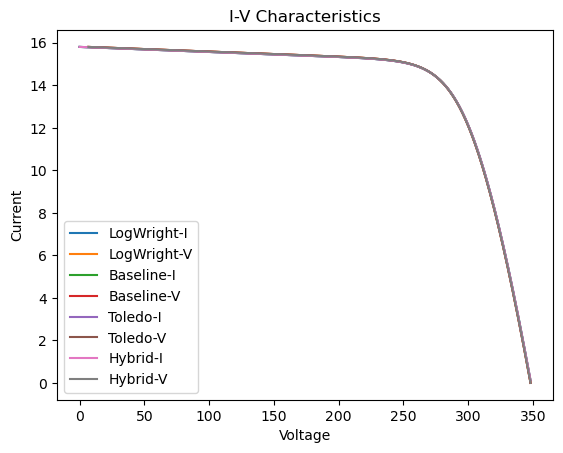

,LogWright-I,LogWright-V,Baseline-I,Baseline-V,Toledo-I,Toledo-V,Hybrid-I,Hybrid-V
mean time,0.000874,0.001030,0.001704,0.001722,0.000992,0.001072,0.000813,0.000776
median time,0.000865,0.001025,0.001696,0.001701,0.000978,0.001060,0.000805,0.000769
max time,0.001592,0.002041,0.003257,0.003446,0.001864,0.001970,0.001535,0.001432
min time,0.000832,0.000990,0.001656,0.001656,0.000946,0.001022,0.000769,0.000729


In [24]:
from collections import defaultdict
from tqdm import tqdm

# Parameter Set 1
I_ph = 15.88
I_sat = 7.44e-10
a = 14.67
R_s = 2.04
R_sh = 425.2
I_sc = 15.804
V_oc = 348.1

# Giving a wide range of values
num_iterations = 20000
num_steps = 1000
metrics = {}
proc_times = defaultdict(lambda: [])
#plt.figure(figsize=(11,7))

for algo in ["LogWright","Baseline","Toledo","Hybrid"]:
    for approach in ["I","V"]:
        label = algo+"-"+approach
        solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
        #curr, volt, proc_times = solver.solve_for_iv_char(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_iters=num_iterations)
        #step = I_sc/num_steps if approach=="V" else V_oc/num_steps
        curr, volt, proc_times = solver.get_iv_char_time(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps, num_iters=num_iterations)
        metrics[label] = {}
        metrics[label]["mean time"] = np.mean(proc_times)
        metrics[label]["median time"] = np.median(proc_times)
        metrics[label]["max time"] = np.max(proc_times)
        metrics[label]["min time"] = np.min(proc_times)
        plt.plot(volt, curr, label=label)
plt.legend()
plt.title("I-V Characteristics")
plt.xlabel("Voltage")
plt.ylabel("Current")
plt.show()
metrics_df = pd.DataFrame(metrics)
metrics_df

### Parameter Set 2

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:34<00:00, 586.47it/s]
/home/prabhat/.miniconda3/envs/lambert-w/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:15<00:00, 1277.60it/s]


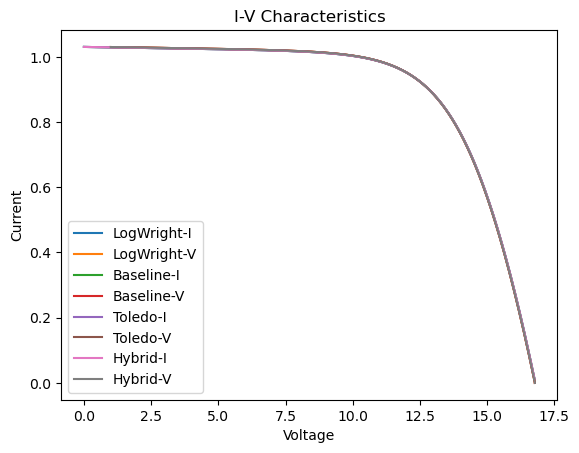

,LogWright-I,LogWright-V,Baseline-I,Baseline-V,Toledo-I,Toledo-V,Hybrid-I,Hybrid-V
mean time,0.000934,0.001046,0.001695,0.001708,0.001017,0.001075,0.000810,0.000778
median time,0.000923,0.001036,0.001678,0.001686,0.000998,0.001065,0.000805,0.000772
max time,0.001784,0.001852,0.003804,0.003509,0.002427,0.002427,0.001587,0.001497
min time,0.000879,0.001002,0.001634,0.001640,0.000954,0.001026,0.000771,0.000738


In [23]:
# Parameter Set 2
I_ph = 1.032
I_sat = 2.513e-6
R_s = 1.239
R_sh = 744.714
a = 1.3
I_sc = 1.031
V_oc = 16.775

# Giving a wide range of values
num_iterations = 20000
num_steps = 1000
metrics = {}
proc_times = defaultdict(lambda: [])
#plt.figure(figsize=(11,7))

for algo in ["LogWright","Baseline","Toledo","Hybrid"]:
    for approach in ["I","V"]:
        label = algo+"-"+approach
        solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
        #curr, volt, proc_times = solver.solve_for_iv_char(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_iters=num_iterations)
        #step = I_sc/num_steps if approach=="V" else V_oc/num_steps
        curr, volt, proc_times = solver.get_iv_char_time(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps, num_iters=num_iterations)
        metrics[label] = {}
        metrics[label]["mean time"] = np.mean(proc_times)
        metrics[label]["median time"] = np.median(proc_times)
        metrics[label]["max time"] = np.max(proc_times)
        metrics[label]["min time"] = np.min(proc_times)
        plt.plot(volt, curr, label=label)
plt.legend()
plt.title("I-V Characteristics")
plt.xlabel("Voltage")
plt.ylabel("Current")
plt.show()
metrics_df = pd.DataFrame(metrics)
metrics_df

### Parameter Set 3

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:36<00:00, 552.98it/s]
/home/prabhat/.miniconda3/envs/lambert-w/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Skipping Baseline-V due to OverflowError


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:16<00:00, 1227.65it/s]


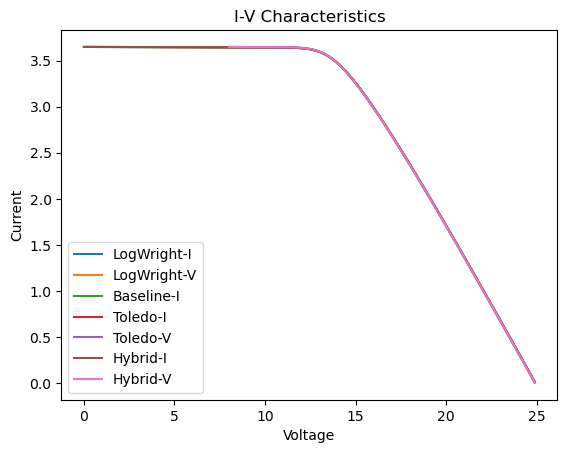

,LogWright-I,LogWright-V,Baseline-I,Toledo-I,Toledo-V,Hybrid-I,Hybrid-V
mean time,0.000955,0.000883,0.001798,0.001122,0.000921,0.000841,0.000810
median time,0.000950,0.000870,0.001793,0.001112,0.000915,0.000839,0.000807
max time,0.001698,0.002515,0.003372,0.002781,0.001450,0.001159,0.001585
min time,0.000916,0.000842,0.001741,0.001074,0.000881,0.000805,0.000774


In [15]:
# Parameter Set 3
I_ph = 3.654
I_sat = 3.999e-21
R_s = 2.69
R_sh = 2329
a = 0.516
I_sc = 3.650
V_oc = 24.893

# Giving a wide range of values
num_iterations = 20000
num_steps = 1000
metrics = {}
proc_times = defaultdict(lambda: [])
#plt.figure(figsize=(11,7))

for algo in ["LogWright","Baseline","Toledo","Hybrid"]:
#for algo in ["LogWright","Toledo","Hybrid"]:
    for approach in ["I","V"]:
        label = algo+"-"+approach
        try:
            solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
            #curr, volt, proc_times = solver.solve_for_iv_char(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_iters=num_iterations)
            #step = I_sc/num_steps if approach=="V" else V_oc/num_steps
            curr, volt, proc_times = solver.get_iv_char_time(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps, num_iters=num_iterations)
            metrics[label] = {}
            metrics[label]["mean time"] = np.mean(proc_times)
            metrics[label]["median time"] = np.median(proc_times)
            metrics[label]["max time"] = np.max(proc_times)
            metrics[label]["min time"] = np.min(proc_times)
            plt.plot(volt, curr, label=label)
        except OverflowError:
            print(f"Skipping {label} due to OverflowError")
            continue
plt.legend()
plt.title("I-V Characteristics")
plt.xlabel("Voltage")
plt.ylabel("Current")
plt.show()
metrics_df = pd.DataFrame(metrics)
metrics_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:35<00:00, 562.47it/s]
/home/prabhat/.miniconda3/envs/lambert-w/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Skipping Baseline-V due to OverflowError


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:16<00:00, 1238.79it/s]


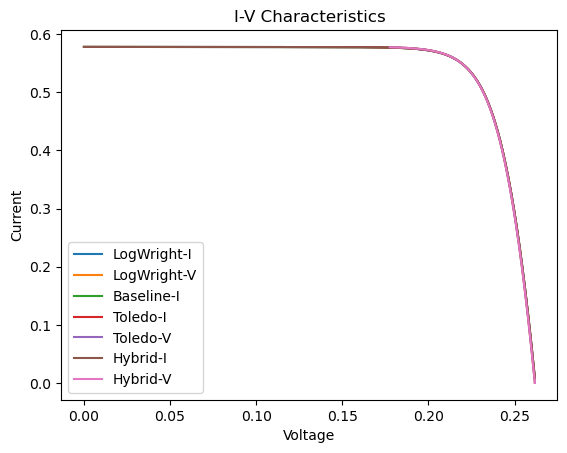

,LogWright-I,LogWright-V,Baseline-I,Toledo-I,Toledo-V,Hybrid-I,Hybrid-V
mean time,0.000870,0.000877,0.001768,0.000986,0.000917,0.000830,0.000802
median time,0.000866,0.000873,0.001759,0.000979,0.000905,0.000821,0.000797
max time,0.001539,0.001691,0.003549,0.002183,0.002573,0.001703,0.002230
min time,0.000827,0.000843,0.001720,0.000942,0.000869,0.000785,0.000762


In [12]:
# Parameter Set 4
I_ph = 0.578
I_sat = 1.34e-10
R_s = 0.0127
R_sh = 612
a = 0.0118
I_sc = 0.578
V_oc = 0.262

# Giving a wide range of values
num_iterations = 20000
num_steps = 1000
metrics = {}
proc_times = defaultdict(lambda: [])
#plt.figure(figsize=(11,7))

for algo in ["LogWright","Baseline","Toledo","Hybrid"]:
#for algo in ["LogWright","Toledo","Hybrid"]:
    for approach in ["I","V"]:
        label = algo+"-"+approach
        try:
            solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
            #curr, volt, proc_times = solver.solve_for_iv_char(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_iters=num_iterations)
            #step = I_sc/num_steps if approach=="V" else V_oc/num_steps
            curr, volt, proc_times = solver.get_iv_char_time(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps, num_iters=num_iterations)
            metrics[label] = {}
            metrics[label]["mean time"] = np.mean(proc_times)
            metrics[label]["median time"] = np.median(proc_times)
            metrics[label]["max time"] = np.max(proc_times)
            metrics[label]["min time"] = np.min(proc_times)
            plt.plot(volt, curr, label=label)
        except OverflowError:
            print(f"Skipping {label} due to OverflowError")
            continue
plt.legend()
plt.title("I-V Characteristics")
plt.xlabel("Voltage")
plt.ylabel("Current")
plt.show()
metrics_df = pd.DataFrame(metrics)
metrics_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:34<00:00, 585.70it/s]
/home/prabhat/.miniconda3/envs/lambert-w/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Skipping Baseline-V due to OverflowError


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:15<00:00, 1283.52it/s]


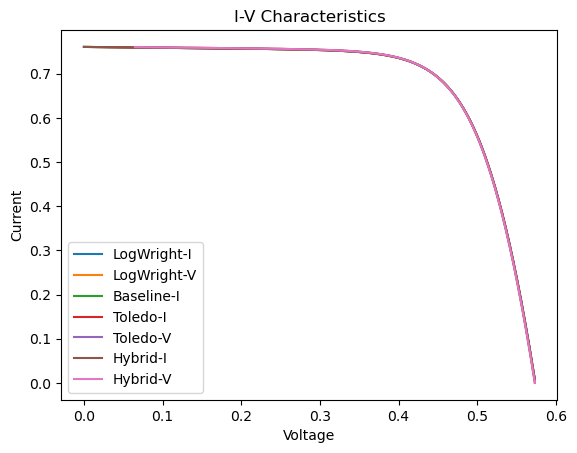

,LogWright-I,LogWright-V,Baseline-I,Toledo-I,Toledo-V,Hybrid-I,Hybrid-V
mean time,0.000905,0.001056,0.001698,0.000993,0.001079,0.000810,0.000775
median time,0.000900,0.001051,0.001684,0.000980,0.001071,0.000804,0.000772
max time,0.001642,0.001962,0.003582,0.002030,0.001854,0.001696,0.001284
min time,0.000860,0.001013,0.001646,0.000939,0.001022,0.000771,0.000737


In [13]:
# Parameter Set 5
I_ph = 0.761
I_sat = 3.107e-7
R_s = 0.037
R_sh = 52.89
a = 0.039
I_sc = 0.760
V_oc = 0.573

# Giving a wide range of values
num_iterations = 20000
num_steps = 1000
metrics = {}
proc_times = defaultdict(lambda: [])
#plt.figure(figsize=(11,7))

for algo in ["LogWright","Baseline","Toledo","Hybrid"]:
#for algo in ["LogWright","Toledo","Hybrid"]:
    for approach in ["I","V"]:
        label = algo+"-"+approach
        try:
            solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
            #curr, volt, proc_times = solver.solve_for_iv_char(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_iters=num_iterations)
            #step = I_sc/num_steps if approach=="V" else V_oc/num_steps
            curr, volt, proc_times = solver.get_iv_char_time(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps, num_iters=num_iterations)
            metrics[label] = {}
            metrics[label]["mean time"] = np.mean(proc_times)
            metrics[label]["median time"] = np.median(proc_times)
            metrics[label]["max time"] = np.max(proc_times)
            metrics[label]["min time"] = np.min(proc_times)
            plt.plot(volt, curr, label=label)
        except OverflowError:
            print(f"Skipping {label} due to OverflowError")
            continue
plt.legend()
plt.title("I-V Characteristics")
plt.xlabel("Voltage")
plt.ylabel("Current")
plt.show()
metrics_df = pd.DataFrame(metrics)
metrics_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:36<00:00, 541.43it/s]
/home/prabhat/.miniconda3/envs/lambert-w/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Skipping Baseline-V due to OverflowError


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:16<00:00, 1223.30it/s]


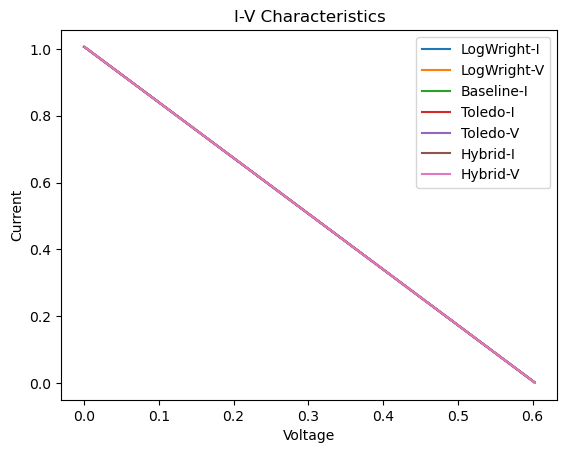

,LogWright-I,LogWright-V,Baseline-I,Toledo-I,Toledo-V,Hybrid-I,Hybrid-V
mean time,0.001102,0.000868,0.001837,0.001150,0.000894,0.000847,0.000813
median time,0.001096,0.000862,0.001823,0.001145,0.000885,0.000843,0.000808
max time,0.001922,0.001371,0.002924,0.001998,0.002461,0.001721,0.001488
min time,0.001050,0.000828,0.001765,0.001102,0.000854,0.000812,0.000764


In [14]:
# Parameter Set 6
I_ph = 4.802
I_sat = 4.016e-7
R_s = 0.5906
R_sh = 1167
a = 0.037
I_sc = 1.006
V_oc = 0.603

# Giving a wide range of values
num_iterations = 20000
num_steps = 1000
metrics = {}
proc_times = defaultdict(lambda: [])
#plt.figure(figsize=(11,7))

for algo in ["LogWright","Baseline","Toledo","Hybrid"]:
#for algo in ["LogWright","Toledo","Hybrid"]:
    for approach in ["I","V"]:
        label = algo+"-"+approach
        try:
            solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
            #curr, volt, proc_times = solver.solve_for_iv_char(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_iters=num_iterations)
            #step = I_sc/num_steps if approach=="V" else V_oc/num_steps
            curr, volt, proc_times = solver.get_iv_char_time(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps, num_iters=num_iterations)
            metrics[label] = {}
            metrics[label]["mean time"] = np.mean(proc_times)
            metrics[label]["median time"] = np.median(proc_times)
            metrics[label]["max time"] = np.max(proc_times)
            metrics[label]["min time"] = np.min(proc_times)
            plt.plot(volt, curr, label=label)
        except OverflowError:
            print(f"Skipping {label} due to OverflowError")
            continue
plt.legend()
plt.title("I-V Characteristics")
plt.xlabel("Voltage")
plt.ylabel("Current")
plt.show()
metrics_df = pd.DataFrame(metrics)
metrics_df

**Observation while experimenting with code**:

- while loop seems to be much faster than a for loop. The logwright function evaluation (in fact, all function evaluations) is much faster when using a while loop! Is that a result of some kind of optimization in python?

In [17]:
# Resetting Parameter Set 1
I_ph = 15.88
I_sat = 7.44e-10
a = 14.67
R_s = 2.04
R_sh = 425.2
I_sc = 15.804
V_oc = 348.1

## Experiment 3: Which time metric is more stable?

In [11]:
from collections import defaultdict
from tqdm import tqdm

# Giving a wide range of values
num_iterations = 20000
num_steps = 100
metrics = defaultdict(lambda: {})
plt.figure(figsize=(11,7))

for i in range(3):
    for algo in ["LogWright","Baseline","Toledo","Hybrid"]:
        for approach in ["I","V"]:
            label = algo+"-"+approach
            solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
            curr, volt, proc_times = solver.get_iv_char_time(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps, num_iters=num_iterations)
            metrics[label][f"mean time {i}"] = np.mean(proc_times)
            metrics[label][f"median time {i}"] = np.median(proc_times)
            metrics[label][f"max time {i}"] = np.max(proc_times)
            metrics[label][f"min time {i}"] = np.min(proc_times)
metrics_df = pd.DataFrame(metrics)
metrics_df

100%|█████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:01<00:00, 12514.55it/s]


,LogWright-I,LogWright-V,Baseline-I,Baseline-V,Toledo-I,Toledo-V,Hybrid-I,Hybrid-V
mean time 0,8.091087e-05,9.635940e-05,1.741483e-04,1.779434e-04,9.721946e-05,1.084866e-04,8.077987e-05,7.692126e-05
median time 0,8.058548e-05,9.584427e-05,1.733303e-04,1.757145e-04,9.608269e-05,1.084805e-04,7.867813e-05,7.605553e-05
max time 0,2.818108e-04,3.025532e-04,5.562305e-04,5.223751e-04,4.343987e-04,4.003048e-04,3.950596e-04,4.243851e-04
min time 0,7.390976e-05,9.274483e-05,1.609325e-04,1.676083e-04,9.036064e-05,9.846687e-05,7.557869e-05,6.866455e-05
mean time 1,8.197576e-05,1.011876e-04,1.780514e-04,1.773602e-04,9.713345e-05,1.083743e-04,7.945062e-05,7.695869e-05
median time 1,8.058548e-05,9.632111e-05,1.733303e-04,1.761913e-04,9.560585e-05,1.084805e-04,7.867813e-05,7.629395e-05
max time 1,3.244877e-04,4.196167e-04,5.528927e-04,5.075932e-04,3.545284e-04,3.411770e-04,3.271103e-04,3.123283e-04
min time 1,7.796288e-05,9.274483e-05,1.649857e-04,1.618862e-04,9.107590e-05,9.894371e-05,7.486343e-05,7.367134e-05
mean time 2,8.180306e-05,9.646089e-05,1.755603e-04,1.759266e-04,9.734384e-05,1.090636e-04,7.884091e-05,7.810678e-05
median time 2,8.058548e-05,9.560585e-05,1.745224e-04,1.754761e-04,9.632111e-05,1.084805e-04,7.843971e-05,7.772446e-05


<Figure size 1100x700 with 0 Axes>

In [14]:
metrics_df.sort_index()

,LogWright-I,LogWright-V,Baseline-I,Baseline-V,Toledo-I,Toledo-V,Hybrid-I,Hybrid-V
max time 0,2.818108e-04,3.025532e-04,5.562305e-04,5.223751e-04,4.343987e-04,4.003048e-04,3.950596e-04,4.243851e-04
max time 1,3.244877e-04,4.196167e-04,5.528927e-04,5.075932e-04,3.545284e-04,3.411770e-04,3.271103e-04,3.123283e-04
max time 2,3.430843e-04,3.087521e-04,4.942417e-04,4.284382e-04,4.055500e-04,3.967285e-04,3.545284e-04,3.135204e-04
mean time 0,8.091087e-05,9.635940e-05,1.741483e-04,1.779434e-04,9.721946e-05,1.084866e-04,8.077987e-05,7.692126e-05
mean time 1,8.197576e-05,1.011876e-04,1.780514e-04,1.773602e-04,9.713345e-05,1.083743e-04,7.945062e-05,7.695869e-05
mean time 2,8.180306e-05,9.646089e-05,1.755603e-04,1.759266e-04,9.734384e-05,1.090636e-04,7.884091e-05,7.810678e-05
median time 0,8.058548e-05,9.584427e-05,1.733303e-04,1.757145e-04,9.608269e-05,1.084805e-04,7.867813e-05,7.605553e-05
median time 1,8.058548e-05,9.632111e-05,1.733303e-04,1.761913e-04,9.560585e-05,1.084805e-04,7.867813e-05,7.629395e-05
median time 2,8.058548e-05,9.560585e-05,1.745224e-04,1.754761e-04,9.632111e-05,1.084805e-04,7.843971e-05,7.772446e-05
min time 0,7.390976e-05,9.274483e-05,1.609325e-04,1.676083e-04,9.036064e-05,9.846687e-05,7.557869e-05,6.866455e-05


**Observations**

- Median time seems to be more stable than mean/min/max time (mean is also somewhat stable). Let's consider median time as the time metric.

## Experiment 4: How does the process time look like across values of input argument?

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8110.63it/s]


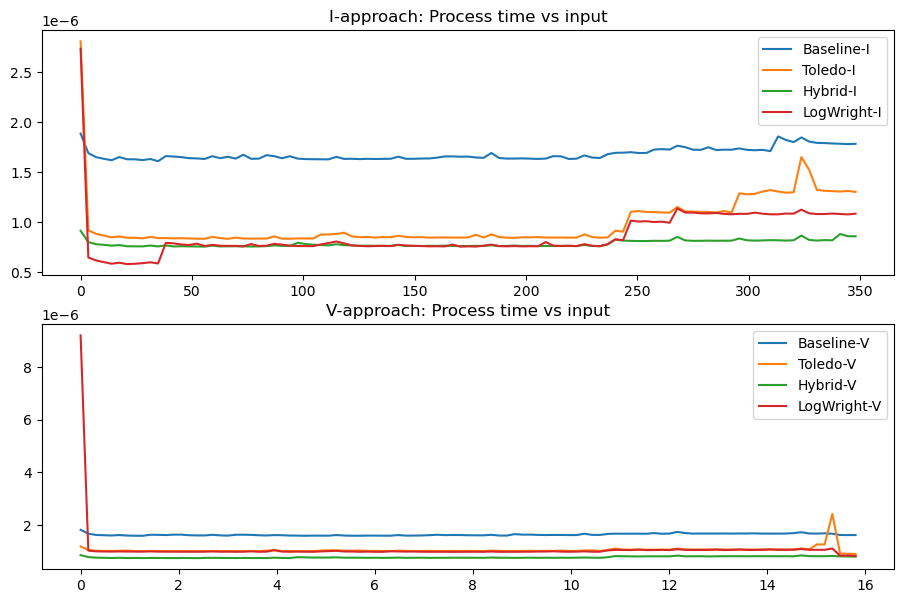

In [4]:
from collections import defaultdict
from tqdm import tqdm

# Giving a wide range of values
num_steps = 100
num_iterations = 10000
metrics = {}
proc_times = defaultdict(lambda: [])
plt.figure(figsize=(11,7))

for algo in ["Baseline","Toledo","Hybrid","LogWright"]:
    for approach in ["I","V"]:
        solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
        curr, volt, times = solver.profile_iv_char_time(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps, num_iters=num_iterations, time_metric="mean")
        
        plt_no = 1 if approach == "I" else 2
        x_vals = curr if approach=="V" else volt
        plt.subplot(2,1,plt_no)
        plt.plot(x_vals, times, label=algo+"-"+approach)
        plt.legend()
        plt.title(f"{approach}-approach: Process time vs input")
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8146.21it/s]


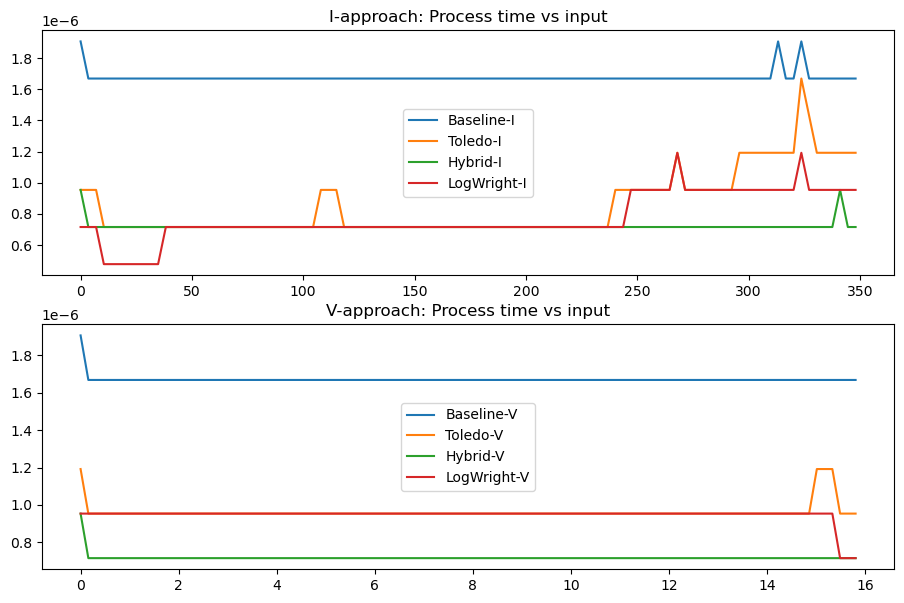

In [5]:
from collections import defaultdict
from tqdm import tqdm

# Giving a wide range of values
num_steps = 100
num_iterations = 10000
metrics = {}
proc_times = defaultdict(lambda: [])
plt.figure(figsize=(11,7))

for algo in ["Baseline","Toledo","Hybrid","LogWright"]:
    for approach in ["I","V"]:
        solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
        curr, volt, times = solver.profile_iv_char_time(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps, num_iters=num_iterations, time_metric="median")
        
        plt_no = 1 if approach == "I" else 2
        x_vals = curr if approach=="V" else volt
        plt.subplot(2,1,plt_no)
        plt.plot(x_vals, times, label=algo+"-"+approach)
        plt.legend()
        plt.title(f"{approach}-approach: Process time vs input")
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:04<00:00, 309.78it/s]


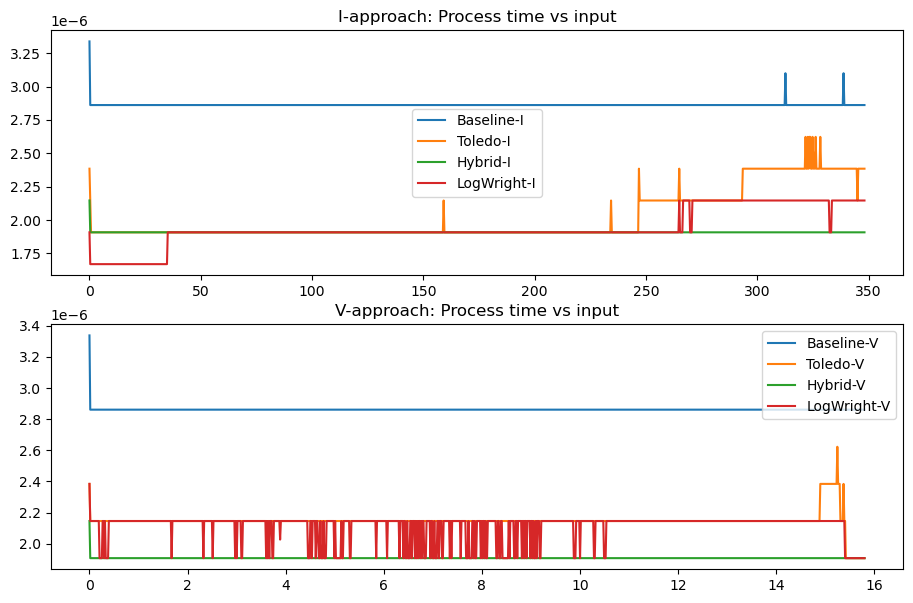

In [13]:
from collections import defaultdict
from tqdm import tqdm

# Giving a wide range of values
num_steps = 1000
num_iterations = 20000
metrics = {}
proc_times = defaultdict(lambda: [])
plt.figure(figsize=(11,7))

for algo in ["Baseline","Toledo","Hybrid","LogWright"]:
    for approach in ["I","V"]:
        solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
        curr, volt, times = solver.profile_iv_char_time(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps, num_iters=num_iterations)
        
        plt_no = 1 if approach == "I" else 2
        x_vals = curr if approach=="V" else volt
        plt.subplot(2,1,plt_no)
        plt.plot(x_vals, times, label=algo+"-"+approach)
        plt.legend()
        plt.title(f"{approach}-approach: Process time vs input")
plt.show()

## Experiment 5: How does tolerance affect process time?

In [15]:
from collections import defaultdict
from tqdm import tqdm

# Giving a wide range of values
num_steps = 100
num_iterations = 10000
metrics = defaultdict(lambda: {})
inps = {}
all_proc_times = {}

for tol in [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]:
    for algo in ["Baseline","LogWright","Toledo","Hybrid"]:
        for approach in ["I","V"]:
            label = algo+"-"+approach
            solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach, tol=tol)
            I,V,proc_times = solver.get_iv_char_time(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps, num_iters=num_iterations)
            inps[approach] = V if approach=="I" else V
            metrics[label][f"mean tol={tol}"] = np.mean(proc_times)
            metrics[label][f"median tol={tol}"] = np.median(proc_times)
            metrics[label][f"min tol={tol}"] = np.max(proc_times)
            metrics[label][f"max tol={tol}"] = np.min(proc_times)
            all_proc_times[label] = proc_times

metrics_df = pd.DataFrame(metrics)
pd.options.display.float_format = "{:e}".format
metrics_df.sort_index()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 12455.06it/s]


,Baseline-I,Baseline-V,LogWright-I,LogWright-V,Toledo-I,Toledo-V,Hybrid-I,Hybrid-V
max tol=0.0001,1.661777e-04,1.645088e-04,6.842613e-05,7.748604e-05,8.821487e-05,8.177757e-05,7.414818e-05,7.367134e-05
max tol=0.001,1.628399e-04,1.645088e-04,6.532669e-05,7.748604e-05,8.630753e-05,7.915497e-05,7.534027e-05,7.462502e-05
max tol=1e-05,1.633167e-04,1.649857e-04,7.128716e-05,8.010864e-05,8.964539e-05,8.296967e-05,7.534027e-05,7.438660e-05
max tol=1e-06,1.642704e-04,1.654625e-04,7.247925e-05,8.606911e-05,9.036064e-05,9.131432e-05,7.605553e-05,7.486343e-05
max tol=1e-07,1.635551e-04,1.666546e-04,7.557869e-05,9.346008e-05,9.131432e-05,1.003742e-04,7.534027e-05,7.486343e-05
max tol=1e-08,1.640320e-04,1.685619e-04,7.653236e-05,9.393692e-05,9.226799e-05,1.015663e-04,7.653236e-05,7.319450e-05
max tol=1e-09,1.645088e-04,1.688004e-04,7.915497e-05,9.298325e-05,9.083748e-05,9.942055e-05,7.534027e-05,7.367134e-05
mean tol=0.0001,1.747296e-04,1.745144e-04,7.280214e-05,8.229933e-05,9.248283e-05,8.560936e-05,8.047497e-05,7.881198e-05
mean tol=0.001,1.732641e-04,1.737076e-04,6.804433e-05,8.054631e-05,9.118714e-05,8.486063e-05,8.042855e-05,7.768779e-05
mean tol=1e-05,1.749689e-04,1.745257e-04,7.508535e-05,8.343904e-05,9.323483e-05,8.724494e-05,8.023131e-05,7.895584e-05


**Observations**:

- As expected, increasing the tolerance increases the computation time by a bit.

- Median time is more stable than mean time, and hence a better time metric than others. The max time and min time are noisy due to other processes that run on my computer, thereby making both of them bad metrics to measure the algorithm speed. Median time seems to be the best!

- Small multiplication optimizations seem to make lots of difference!

## Experiment 6: Variation of the function argument with input

/home/prabhat/.miniconda3/envs/lambert-w/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


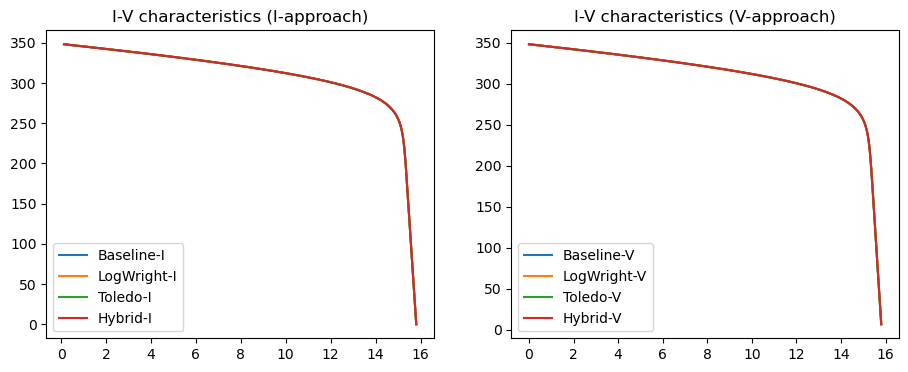

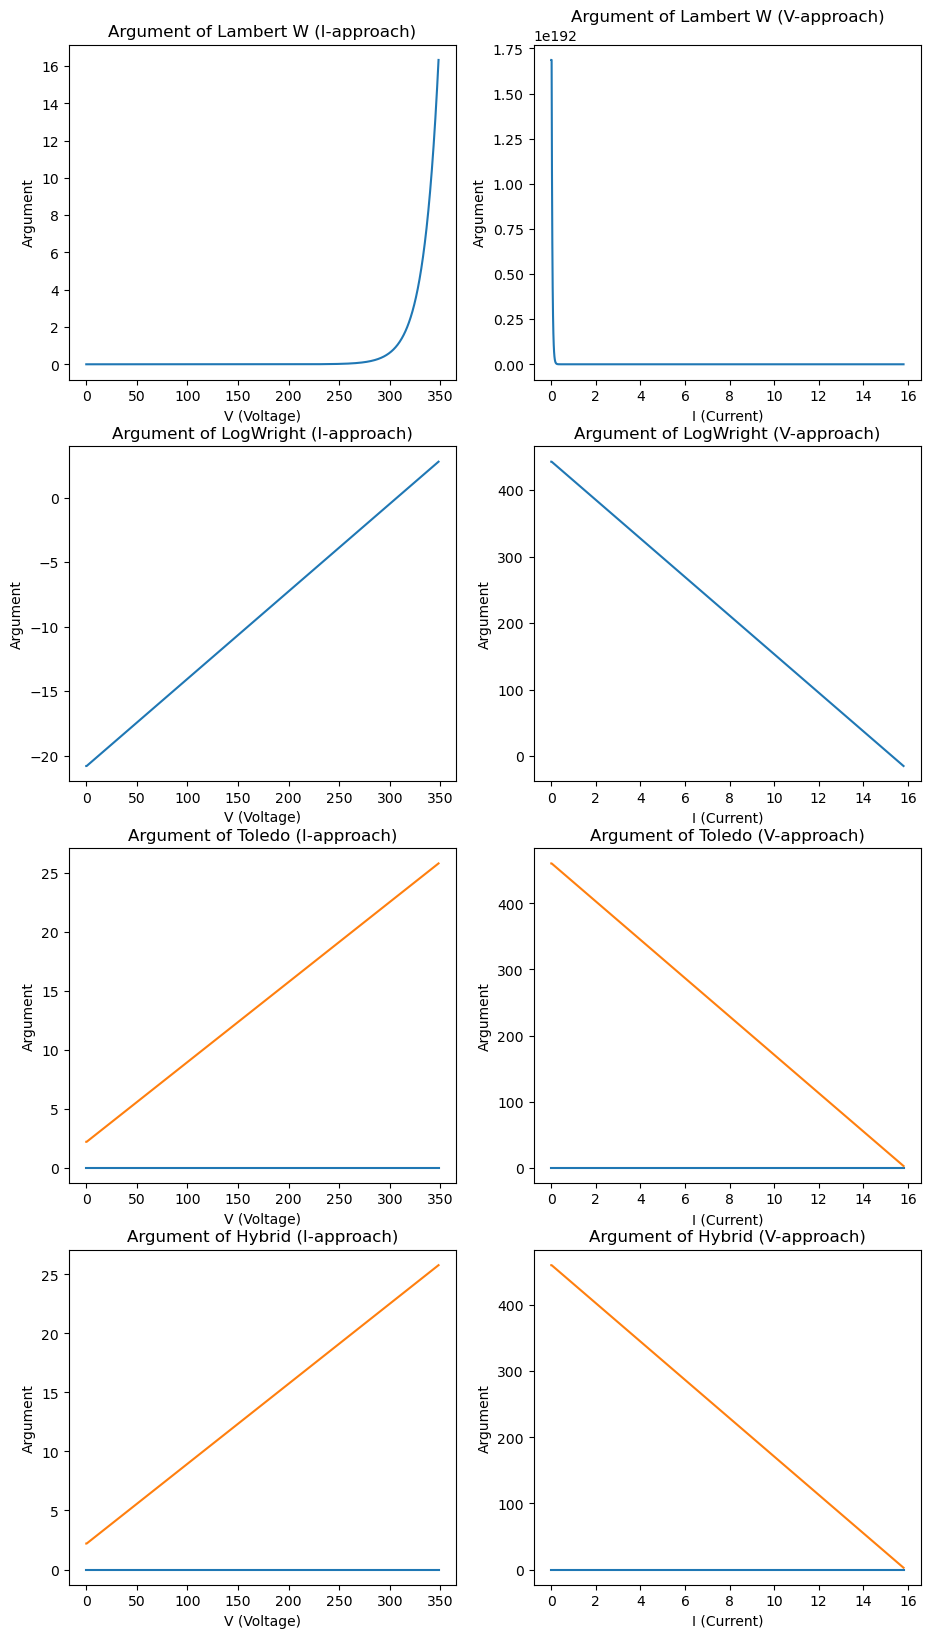

In [9]:
# Giving a wide range of values

num_steps = 1000
curr_dict = {}
volt_dict = {}
fn_arg_dict = {}

plt.figure(figsize=(11,4))
for i, approach in enumerate(["I","V"]):
    plt.subplot(1,2,i+1)
    for algo in ["Baseline","LogWright","Toledo","Hybrid"]:
        label = algo+"-"+approach
        solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
        I,V,fn_arg = solver.solve_for_iv_char_witharg(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps)
        curr_dict[label] = I
        volt_dict[label] = V
        fn_arg_dict[label] = fn_arg
        plt.plot(I,V,label=label)
    plt.title(f"I-V characteristics ({approach}-approach)")
    plt.legend()
plt.show()

plt.figure(figsize=(11,20))
for i, algo in enumerate(["Baseline","LogWright","Toledo","Hybrid"]):
    for j, approach in enumerate(["I","V"]):
        label = algo+"-"+approach
        plt.subplot(4,2,i*2+(j+1))
        x_args = curr_dict[label] if approach=="V" else volt_dict[label]
        y_args = fn_arg_dict[label]
        title = ["Lambert W","LogWright","Toledo","Hybrid"][i]
        x_label = ["V (Voltage)", "I (Current)"][j]
        plt.plot(x_args, y_args)
        plt.xlabel(x_label)
        plt.ylabel("Argument")
        plt.title(f"Argument of {title} ({approach}-approach)")
plt.show()

**Note:** The two lines in the plots of Toledo and Hybrid algorithms represent the arguments given to the function. Instead of taking the whole argument $x$, these algorithms take two separate arguments $c, d$ that satisfy $x=ce^d$.

### Parameter Set 2

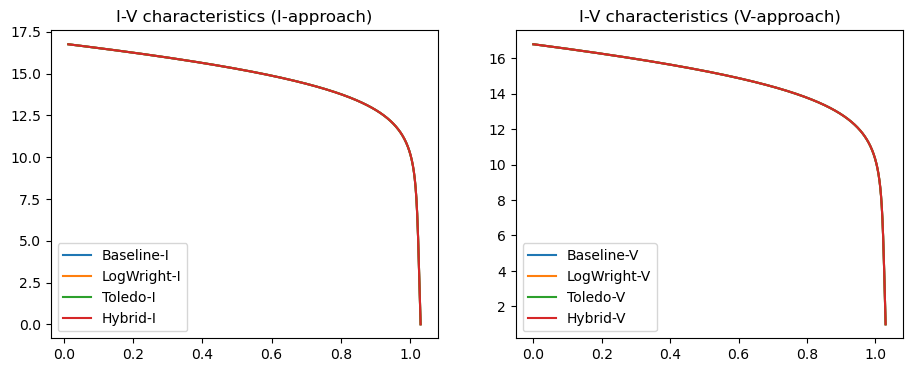

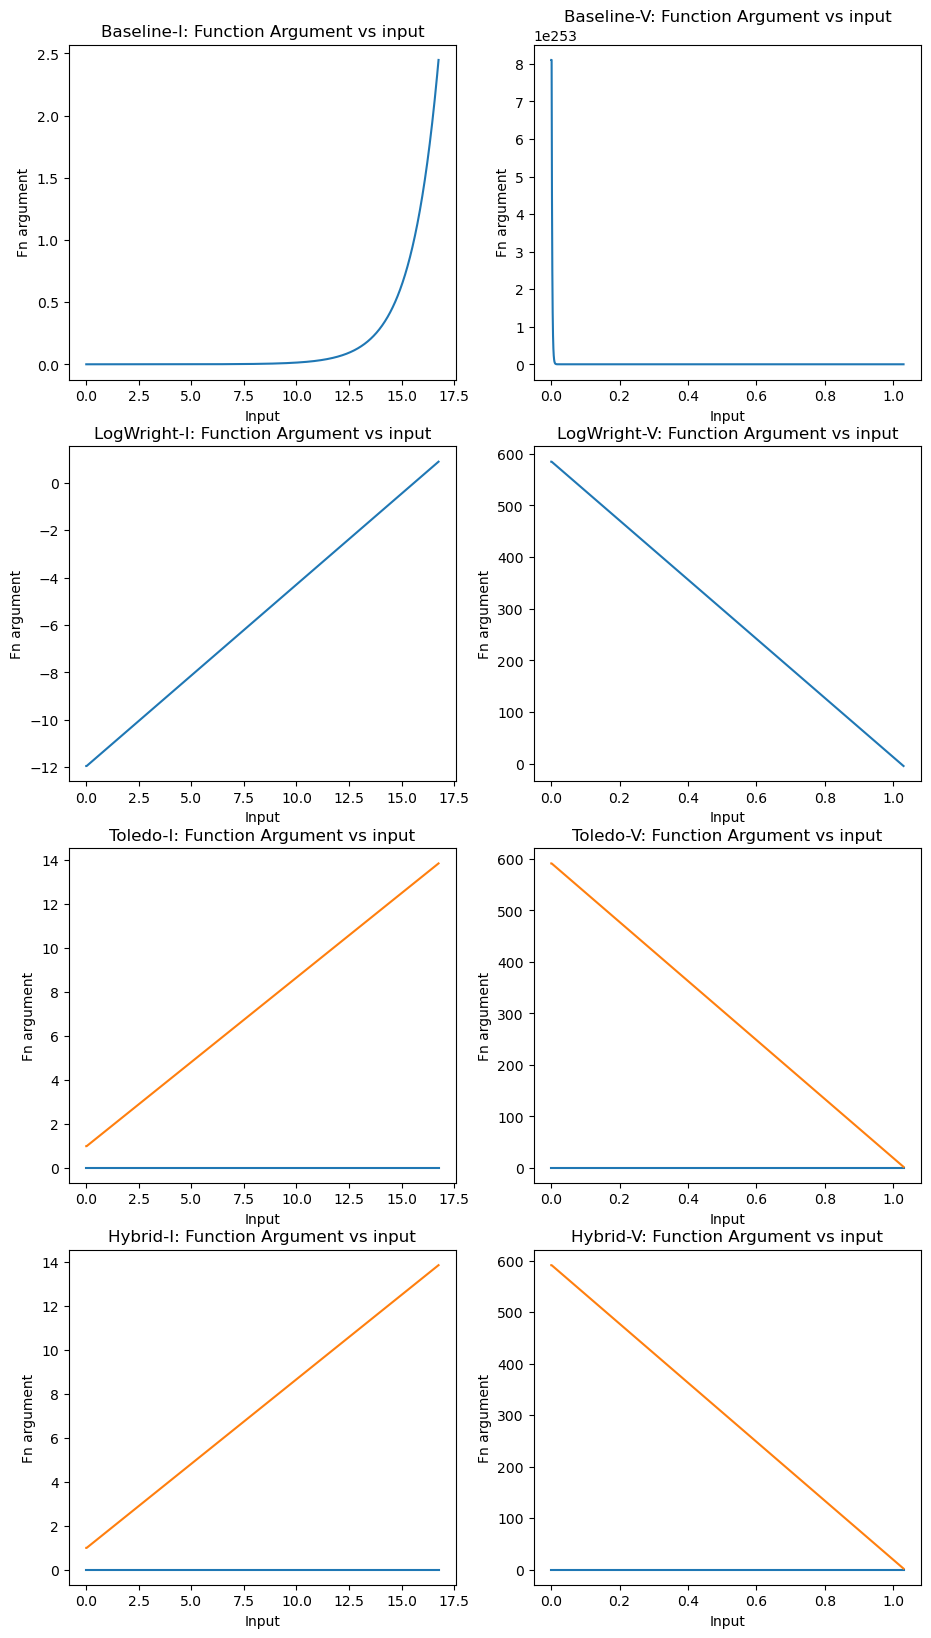

In [20]:
# SDM params
I_ph = 1.032
I_sat = 2.513e-6
R_s = 1.239
R_sh = 744.714
a = 1.3
I_sc = 1.031
V_oc = 16.775

num_steps = 1000
curr_dict = {}
volt_dict = {}
fn_arg_dict = {}

plt.figure(figsize=(11,4))
for i, approach in enumerate(["I","V"]):
    plt.subplot(1,2,i+1)
    for algo in ["Baseline","LogWright","Toledo","Hybrid"]:
        label = algo+"-"+approach
        solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
        I,V,fn_arg = solver.solve_for_iv_char_witharg(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps)
        curr_dict[label] = I
        volt_dict[label] = V
        fn_arg_dict[label] = fn_arg
        plt.plot(I,V,label=label)
    plt.title(f"I-V characteristics ({approach}-approach)")
    plt.legend()
plt.show()

plt.figure(figsize=(11,20))
for i, algo in enumerate(["Baseline","LogWright","Toledo","Hybrid"]):
    for j, approach in enumerate(["I","V"]):
        label = algo+"-"+approach
        plt.subplot(4,2,i*2+(j+1))
        x_args = curr_dict[label] if approach=="V" else volt_dict[label]
        y_args = fn_arg_dict[label]
        plt.plot(x_args, y_args)
        plt.xlabel("Input")
        plt.ylabel("Fn argument")
        plt.title(f"{label}: Function Argument vs input")
plt.show()

### Parameter Set 3

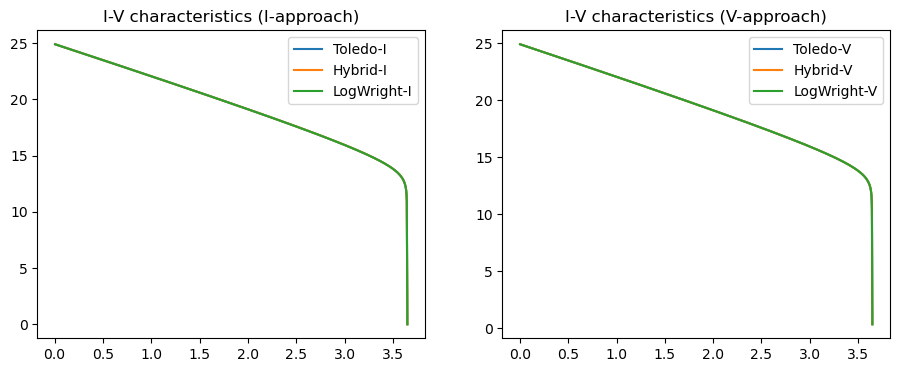

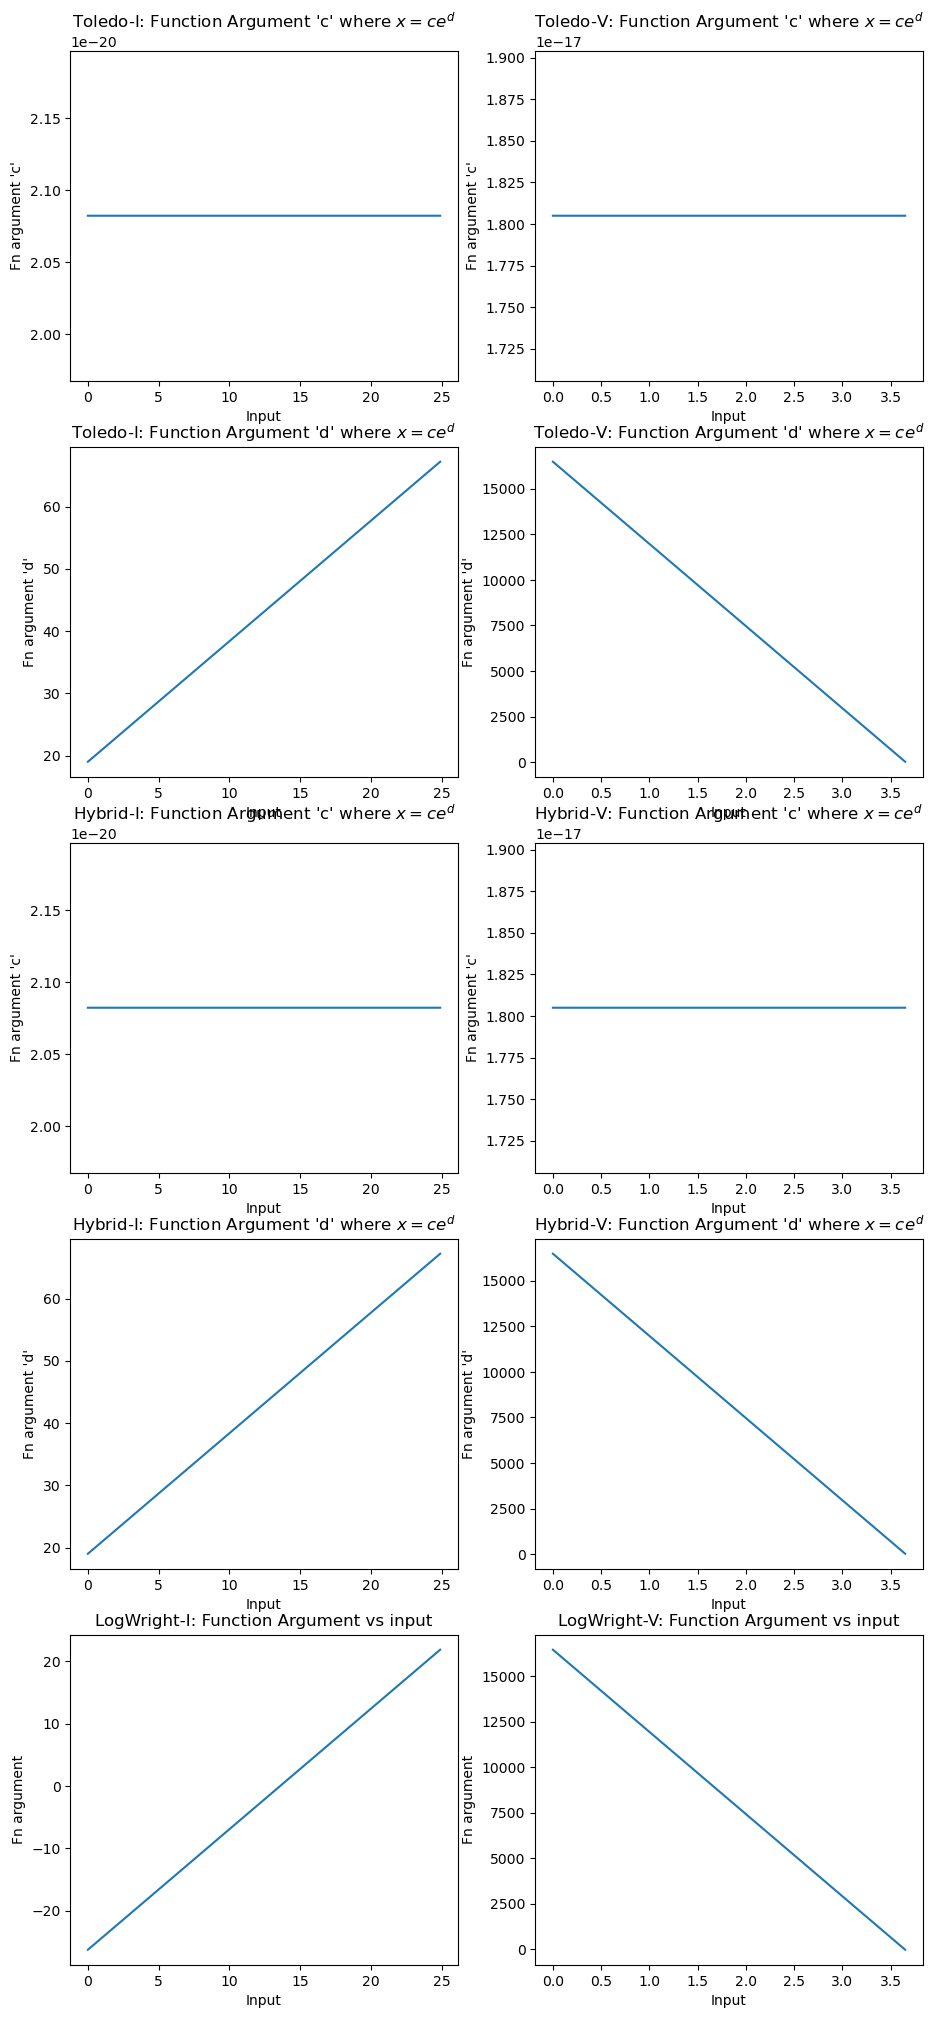

In [19]:
# SDM params
I_ph = 3.654
I_sat = 3.999e-21
R_s = 2.69
R_sh = 2329
a = 0.516
I_sc = 3.650
V_oc = 24.893

num_steps = 10000
curr_dict = {}
volt_dict = {}
fn_arg_dict = {}
#algos = ["Baseline","LogWright","Toledo","Hybrid"]
algos = ["Toledo","Hybrid","LogWright"]

plt.figure(figsize=(11,4))
for i, approach in enumerate(["I","V"]):
    plt.subplot(1,2,i+1)
    for algo in algos:
        label = algo+"-"+approach
        solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
        I,V,fn_arg = solver.solve_for_iv_char_witharg(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps)
        curr_dict[label] = I
        volt_dict[label] = V
        fn_arg_dict[label] = fn_arg
        plt.plot(I,V,label=label)
    plt.title(f"I-V characteristics ({approach}-approach)")
    plt.legend()
plt.show()

plt.figure(figsize=(11,30))
# for i, algo in enumerate(["Baseline","LogWright","Toledo","Hybrid"]):
for i, algo in enumerate(algos):
    for j, approach in enumerate(["I","V"]):
        label = algo+"-"+approach
        x_args = curr_dict[label] if approach=="V" else volt_dict[label]
        y_args = np.array(fn_arg_dict[label])
        if y_args.shape[-1]==2:
            y_args1, y_args2 = y_args[:,0], y_args[:,1]
            plt.subplot(6,2,i*4+(j+1))
            plt.plot(x_args, y_args1)
            plt.xlabel("Input")
            plt.ylabel("Fn argument 'c'")
            plt.title(f"{label}: Function Argument 'c' where $x=ce^d$")
            plt.subplot(6,2,i*4+(j+1)+2)
            plt.plot(x_args, y_args2)
            plt.xlabel("Input")
            plt.ylabel("Fn argument 'd'")
            plt.title(f"{label}: Function Argument 'd' where $x=ce^d$")
        else:
            plt.subplot(6,2,i*4+(j+1))
            plt.plot(x_args, y_args)
            plt.xlabel("Input")
            plt.ylabel("Fn argument")
            plt.title(f"{label}: Function Argument vs input")
plt.show()

**Observations**

- Baseline lambert w encounters overflow error during calculation using parameter set 3.

- Numerical Underflow doesnt matter than much because $W_0(0)=0$. Precision for numbers that small isn't important because the output of the function itself is 0.

- Functions need to be carefully implemented to avoid numerical overflow! Batzelis et al. discusses a trick that can be used to avoid overflow. The idea is to pass in the coefficient and the exponent of $e$ to the function, rather than the whole coefficient i.e. pass in $(a,b)$ to the function where $x=ae^b$.

## Experiment 7: How much memory footprint does an algorithm take?

In [4]:
from memory_profiler import memory_usage

from collections import defaultdict
from tqdm import tqdm

# Giving a wide range of values
num_steps = 100
memory_dict = {}

for algo in ["LogWright","Baseline","Toledo","Hybrid"]:
    for approach in ["I","V"]:
        label = algo+"-"+approach
        solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
        mem = memory_usage((solver.solve_for_iv_char, (I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc), {"num_steps": num_steps}), interval=1e-6, max_usage=True)
        memory_dict[label] = mem

pprint(memory_dict)

{'Baseline-I': 180.8125,
 'Baseline-V': 180.953125,
 'Hybrid-I': 180.9609375,
 'Hybrid-V': 180.96484375,
 'LogWright-I': 170.703125,
 'LogWright-V': 170.70703125,
 'Toledo-I': 180.953125,
 'Toledo-V': 180.953125}


In [8]:
from memory_profiler import memory_usage

from collections import defaultdict
from tqdm import tqdm

# Giving a wide range of values
num_steps = 100
memory_dict = {}

for algo in ["LogWright","Baseline","Toledo","Hybrid"]:
    for approach in ["I","V"]:
        label = algo+"-"+approach
        solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
        mem = memory_usage((solver.solve_for_iv_char, (I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc), {"num_steps": num_steps}), interval=1e-6, max_usage=True)
        memory_dict[label] = mem

pprint(memory_dict)

{'Baseline-I': 181.37109375,
 'Baseline-V': 181.37109375,
 'Hybrid-I': 181.37109375,
 'Hybrid-V': 181.37109375,
 'LogWright-I': 181.37109375,
 'LogWright-V': 181.37109375,
 'Toledo-I': 181.37109375,
 'Toledo-V': 181.37109375}


**Observations**:

- Memory consumption seems to be very small/negligible, and multiple runs are giving inconsistent results. Couldn't find a convenient way to track memory consumption. Maybe asymptotic analysis would be better suited for space complexity analysis.

## Finding Error

Calculating RMSE for outputs, using the `lambertw` function from `scipy` as the baseline

In [33]:
# Parameter Set 1
I_ph = 15.88
I_sat = 7.44e-10
a = 14.67
R_s = 2.04
R_sh = 425.2
I_sc = 15.804
V_oc = 348.1

# Giving a wide range of values
num_steps = 1000
err_baselines = {}
errors = {}

for approach in ["I","V"]:
    label = "Baseline-"+approach
    solver = Solver(solvers["Baseline"][approach], solvers["Baseline"][approach+"_witharg"], name="Baseline", approach=approach)
    curr, volt = solver.solve_for_iv_char(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps)
    out = curr if approach=="I" else volt
    err_baselines[approach] = np.array(out, dtype=np.float64)

for algo in ["Hybrid","Toledo","LogWright"]:
    for approach in ["I","V"]:
        label = algo+"-"+approach
        solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
        curr, volt = solver.solve_for_iv_char(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps)
        out = np.array(curr) if approach=="I" else np.array(volt)
        errors[label] = np.sqrt(np.mean((out-err_baselines[approach])**2)) 

pprint(errors, sort_dicts=False)

{'Hybrid-I': 0.002687957522239788,
 'Hybrid-V': 0.017676746743344032,
 'Toledo-I': 1.2787693799924961e-15,
 'Toledo-V': 2.0771503922264637e-13,
 'LogWright-I': 1.44424541864494e-14,
 'LogWright-V': 4.807846371571803e-13}


/tmp/ipykernel_64318/2900088952.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  err_baselines[approach] = np.array(out, dtype=np.float64)


In [34]:
# Parameter Set 2
I_ph = 1.032
I_sat = 2.513e-6
R_s = 1.239
R_sh = 744.714
a = 1.3
I_sc = 1.031
V_oc = 16.775

# Giving a wide range of values
num_steps = 1000
err_baselines = {}
errors = {}

for approach in ["I","V"]:
    label = "Baseline-"+approach
    solver = Solver(solvers["Baseline"][approach], solvers["Baseline"][approach+"_witharg"], name="Baseline", approach=approach)
    curr, volt = solver.solve_for_iv_char(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps)
    out = curr if approach=="I" else volt
    err_baselines[approach] = np.array(out, dtype=np.float64)

for algo in ["Hybrid","Toledo","LogWright"]:
    for approach in ["I","V"]:
        label = algo+"-"+approach
        solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
        curr, volt = solver.solve_for_iv_char(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps)
        out = np.array(curr) if approach=="I" else np.array(volt)
        errors[label] = np.sqrt(np.mean((out-err_baselines[approach])**2)) 

pprint(errors, sort_dicts=False)

{'Hybrid-I': 0.00011071125980983965,
 'Hybrid-V': 0.0013837427704048349,
 'Toledo-I': 2.135556627277529e-17,
 'Toledo-V': 4.8132100476931034e-14,
 'LogWright-I': 1.234398689508722e-15,
 'LogWright-V': 6.950376082523072e-14}


/tmp/ipykernel_64318/3068494921.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  err_baselines[approach] = np.array(out, dtype=np.float64)


In [35]:
# Parameter Set 3
I_ph = 3.654
I_sat = 3.999e-21
R_s = 2.69
R_sh = 2329
a = 0.516
I_sc = 3.650
V_oc = 24.893

# Giving a wide range of values
num_steps = 1000
err_baselines = {}
errors = {}

valid_approaches = []
for approach in ["I","V"]:
    try:
        label = "Baseline-"+approach
        solver = Solver(solvers["Baseline"][approach], solvers["Baseline"][approach+"_witharg"], name="Baseline", approach=approach)
        curr, volt = solver.solve_for_iv_char(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps)
        out = curr if approach=="I" else volt
        err_baselines[approach] = np.array(out, dtype=np.float64)
        valid_approaches.append(approach)
    except OverflowError:
        print(f"Skipping {approach} approach due to OverflowError")

for algo in ["Hybrid","Toledo","LogWright"]:
    for approach in valid_approaches:
        label = algo+"-"+approach
        solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
        curr, volt = solver.solve_for_iv_char(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps)
        out = np.array(curr) if approach=="I" else np.array(volt)
        errors[label] = np.sqrt(np.mean((out-err_baselines[approach])**2))


pprint(errors, sort_dicts=False)

Skipping V approach due to OverflowError
{'Hybrid-I': 0.0007028054120562822,
 'Toledo-I': 3.8395165608276366e-16,
 'LogWright-I': 1.045055582566068e-15}


/tmp/ipykernel_64318/999732813.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  err_baselines[approach] = np.array(out, dtype=np.float64)


In [36]:
# Parameter Set 4
I_ph = 0.578
I_sat = 1.34e-10
R_s = 0.0127
R_sh = 612
a = 0.0118
I_sc = 0.578
V_oc = 0.262

# Giving a wide range of values
num_steps = 1000
err_baselines = {}
errors = {}

valid_approaches = []
for approach in ["I","V"]:
    try:
        label = "Baseline-"+approach
        solver = Solver(solvers["Baseline"][approach], solvers["Baseline"][approach+"_witharg"], name="Baseline", approach=approach)
        curr, volt = solver.solve_for_iv_char(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps)
        out = curr if approach=="I" else volt
        err_baselines[approach] = np.array(out, dtype=np.float64)
        valid_approaches.append(approach)
    except OverflowError:
        print(f"Skipping {approach} approach due to OverflowError")

for algo in ["Hybrid","Toledo","LogWright"]:
    for approach in valid_approaches:
        label = algo+"-"+approach
        solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
        curr, volt = solver.solve_for_iv_char(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps)
        out = np.array(curr) if approach=="I" else np.array(volt)
        errors[label] = np.sqrt(np.mean((out-err_baselines[approach])**2))


pprint(errors, sort_dicts=False)

Skipping V approach due to OverflowError
{'Hybrid-I': 7.466851493271212e-05,
 'Toledo-I': 7.021666937153402e-18,
 'LogWright-I': 1.3810384777316221e-15}


/tmp/ipykernel_64318/1599029937.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  err_baselines[approach] = np.array(out, dtype=np.float64)


In [37]:
# Parameter Set 5
I_ph = 0.761
I_sat = 3.107e-7
R_s = 0.037
R_sh = 52.89
a = 0.039
I_sc = 0.760
V_oc = 0.573

# Giving a wide range of values
num_steps = 1000
err_baselines = {}
errors = {}

valid_approaches = []
for approach in ["I","V"]:
    try:
        label = "Baseline-"+approach
        solver = Solver(solvers["Baseline"][approach], solvers["Baseline"][approach+"_witharg"], name="Baseline", approach=approach)
        curr, volt = solver.solve_for_iv_char(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps)
        out = curr if approach=="I" else volt
        err_baselines[approach] = np.array(out, dtype=np.float64)
        valid_approaches.append(approach)
    except OverflowError:
        print(f"Skipping {approach} approach due to OverflowError")

for algo in ["Hybrid","Toledo","LogWright"]:
    for approach in valid_approaches:
        label = algo+"-"+approach
        solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
        curr, volt = solver.solve_for_iv_char(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps)
        out = np.array(curr) if approach=="I" else np.array(volt)
        errors[label] = np.sqrt(np.mean((out-err_baselines[approach])**2))


pprint(errors, sort_dicts=False)

Skipping V approach due to OverflowError
{'Hybrid-I': 0.00010412536081438242,
 'Toledo-I': 1.9458786413513082e-17,
 'LogWright-I': 1.0075796403510963e-15}


/tmp/ipykernel_64318/1071296980.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  err_baselines[approach] = np.array(out, dtype=np.float64)


In [38]:
# Parameter Set 6
I_ph = 4.802
I_sat = 4.016e-7
R_s = 0.5906
R_sh = 1167
a = 0.037
I_sc = 1.006
V_oc = 0.603

# Giving a wide range of values
num_steps = 1000
err_baselines = {}
errors = {}

valid_approaches = []
for approach in ["I","V"]:
    try:
        label = "Baseline-"+approach
        solver = Solver(solvers["Baseline"][approach], solvers["Baseline"][approach+"_witharg"], name="Baseline", approach=approach)
        curr, volt = solver.solve_for_iv_char(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps)
        out = curr if approach=="I" else volt
        err_baselines[approach] = np.array(out, dtype=np.float64)
        valid_approaches.append(approach)
    except OverflowError:
        print(f"Skipping {approach} approach due to OverflowError")

for algo in ["Hybrid","Toledo","LogWright"]:
    for approach in valid_approaches:
        label = algo+"-"+approach
        solver = Solver(solvers[algo][approach], solvers[algo][approach+"_witharg"], name=algo, approach=approach)
        curr, volt = solver.solve_for_iv_char(I_ph, I_sat, R_s, R_sh, a, I_sc, V_oc, num_steps=num_steps)
        out = np.array(curr) if approach=="I" else np.array(volt)
        errors[label] = np.sqrt(np.mean((out-err_baselines[approach])**2))


pprint(errors, sort_dicts=False)

Skipping V approach due to OverflowError
{'Hybrid-I': 8.419770647312685e-06,
 'Toledo-I': 5.222534422865635e-16,
 'LogWright-I': 6.312432752751958e-16}


/tmp/ipykernel_64318/708569367.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  err_baselines[approach] = np.array(out, dtype=np.float64)


**Observations**:

- Hybrid method seems to have the highest error, while logwright and toledo methods have negligible errors. This is expected, since hybrid method is an explicit method unlike the other two iterative methods.

The following experiment can show if there is any error due to underflow.

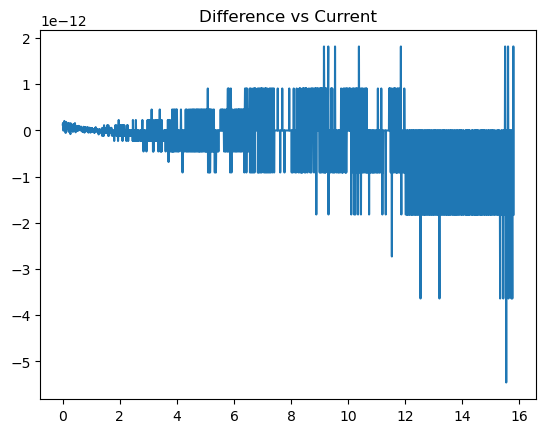

In [60]:
diff = np.array(params_df.loc["V", "Baseline-V"]) - np.array(params_df.loc["V", "LogWright-V"])
curr = params_df.loc["I",method]
plt.plot(curr, diff)
plt.title("Difference vs Current")
plt.show()

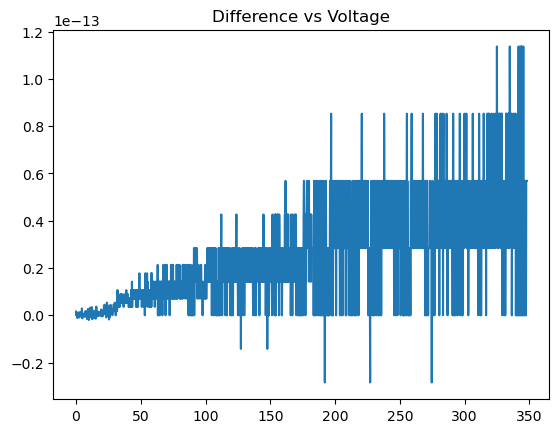

In [69]:
diff = np.array(params_df.loc["I", "Baseline-I"]) - np.array(params_df.loc["I", "LogWright-I"])
curr = params_df.loc["V",method]
plt.plot(curr, diff)
plt.title("Difference vs Voltage")
plt.show()

The plots tell us that there is some small error, but that is negligible. This is probably because output of the lambert w function is 0 if input is 0, so underflow wouldn't cause a large error.